In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
dataset_path = "/content/drive/MyDrive/signatures"

In [3]:
# List the files in the dataset directory
print("Folders in dataset path:", os.listdir(dataset_path))

# Check the number of images in each category
for category in ["full_forg", "full_org"]:
    category_path = os.path.join(dataset_path, category)
    print(f"Number of images in {category}: {len(os.listdir(category_path))}")

Folders in dataset path: ['Readme.txt', 'full_org', 'full_forg']
Number of images in full_forg: 1321
Number of images in full_org: 1321


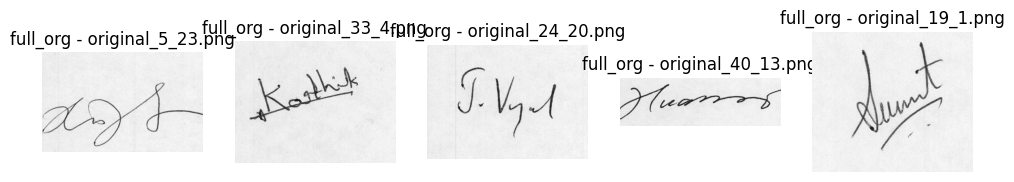

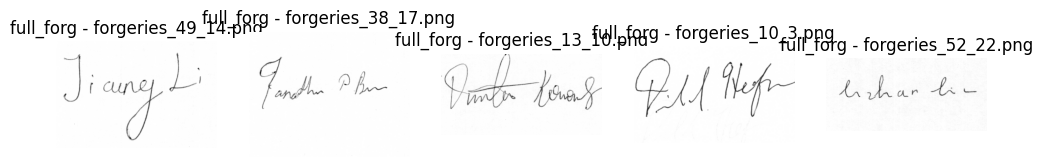

In [4]:
import cv2
import matplotlib.pyplot as plt
import random

# Function to load and display random images
def show_sample_images(category, num_samples=5):
    category_path = os.path.join(dataset_path, category)
    images = random.sample(os.listdir(category_path), num_samples)

    plt.figure(figsize=(12, 4))
    for i, img_name in enumerate(images):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"{category} - {img_name}")
    plt.show()

# Display sample images from both categories
show_sample_images("full_org")   # Genuine signatures
show_sample_images("full_forg")  # Forged signatures


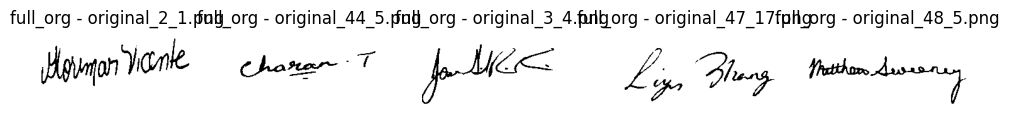

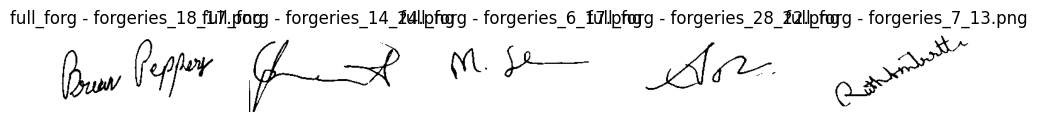

In [7]:
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load grayscale

    if img is None:
        raise ValueError(f"Error loading image: {img_path}")  # Debugging line

    img = cv2.resize(img, (256, 128))  # Resize to a fixed size
    img = cv2.GaussianBlur(img, (3, 3), 0)  # Reduce noise
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Binarization
    return img

# Display preprocessed images
def show_preprocessed_samples(category, num_samples=5):
    category_path = os.path.join(dataset_path, category)
    images = random.sample(os.listdir(category_path), num_samples)

    plt.figure(figsize=(12, 4))
    for i, img_name in enumerate(images):
        img_path = os.path.join(category_path, img_name)
        preprocessed_img = preprocess_image(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(preprocessed_img, cmap='gray')
        plt.axis('off')
        plt.title(f"{category} - {img_name}")
    plt.show()

# Show preprocessed samples
show_preprocessed_samples("full_org")   # Genuine signatures
show_preprocessed_samples("full_forg")  # Forged signatures


In [9]:
import os

# Recursively delete thumbs.db from the dataset
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower() == "thumbs.db":
            file_path = os.path.join(root, file)
            os.remove(file_path)
            print(f"Deleted: {file_path}")

print("All thumbs.db files removed!")


Deleted: /content/drive/MyDrive/signatures/full_org/Thumbs.db
Deleted: /content/drive/MyDrive/signatures/full_forg/Thumbs.db
All thumbs.db files removed!


In [10]:
import numpy as np
from skimage.feature import hog, local_binary_pattern

# Parameters for LBP
LBP_RADIUS = 3
LBP_POINTS = 8 * LBP_RADIUS

# Function to extract features
def extract_features(img_path):
    img = preprocess_image(img_path)  # Apply preprocessing

    # HOG Features
    hog_features = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2),
                       orientations=9, block_norm='L2-Hys', visualize=False)

    # LBP Features
    lbp = local_binary_pattern(img, P=LBP_POINTS, R=LBP_RADIUS, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3), density=True)

    # Hu Moments (Shape Features)
    moments = cv2.moments(img)
    hu_moments = cv2.HuMoments(moments).flatten()

    # Combine features into one array
    return np.hstack([hog_features, lbp_hist, hu_moments])

# Extract features for all images
X = []
y = []

for category, label in [("full_org", 0), ("full_forg", 1)]:  # 0 = Genuine, 1 = Forged
    category_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        X.append(extract_features(img_path))
        y.append(label)

X = np.array(X)
y = np.array(y)

print("Feature extraction complete. Feature shape:", X.shape)

Feature extraction complete. Feature shape: (2640, 3813)


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Split the dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train SVM model
svm_model = SVC(kernel='linear', C=1.0)  # Linear SVM for interpretability
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7556818181818182
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       264
           1       0.77      0.73      0.75       264

    accuracy                           0.76       528
   macro avg       0.76      0.76      0.76       528
weighted avg       0.76      0.76      0.76       528



In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

# Train SVM with best parameters
best_svm = SVC(**grid_search.best_params_)
best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)

# Evaluate
print("Tuned Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameters: {'C': 10, 'kernel': 'rbf'}
Tuned Accuracy: 0.884469696969697
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       264
           1       0.89      0.88      0.88       264

    accuracy                           0.88       528
   macro avg       0.88      0.88      0.88       528
weighted avg       0.88      0.88      0.88       528



In [13]:
from sklearn.decomposition import PCA
import numpy as np

# Apply PCA to find optimal number of components
pca = PCA().fit(X_train)

# Cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain 95% variance
optimal_components = np.argmax(explained_variance >= 0.95) + 1

print(f"Optimal number of components: {optimal_components}")

Optimal number of components: 388


In [14]:
# Apply PCA with optimal components
pca = PCA(n_components=optimal_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train SVM with reduced features
svm_pca = SVC(kernel='rbf', C=10)
svm_pca.fit(X_train_pca, y_train)

# Predictions
y_pred_pca = svm_pca.predict(X_test_pca)

# Evaluate
print("PCA Accuracy:", accuracy_score(y_test, y_pred_pca))
print(classification_report(y_test, y_pred_pca))

PCA Accuracy: 0.8901515151515151
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       264
           1       0.89      0.89      0.89       264

    accuracy                           0.89       528
   macro avg       0.89      0.89      0.89       528
weighted avg       0.89      0.89      0.89       528



In [15]:
!apt-get install git

!git config --global user.name "rithulsandeep"
!git config --global user.email "imrithulsandeep@gmail.com"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
